---
layout: post
title:  "t-SNE"
date:   2023-05-29 10:14:54 +0700
categories: MachineLearning
---

# TOC

- [Introduction](#intro)
- [Distance measurements](#mea)
    - [Cross entropy](#ent)
    - [Kullback–Leibler divergence](#kl)
    - [Jensen Shannon divergence](#js)
- [t-SNE](#tsne)
    - [Stochastic neighbor embedding](#sne)
    - [t-SNE](#tsne2)

# Introduction
t-SNE (or t-Distributed Stochastic Neighbor Embedding), is a machine learning algorithm for visualization of high dimensional data. t-SNE is a dimensionality reduction technique, which is to reduce the features but maintain the most important underlying structure. t-SNE can reduce the dimensions to two or three, making the data easy to be plotted and visually inspected.

In this post, we will first see some methods for distance measurements between distributions and then we build up to the t-SNE algorithm.

# Distance measurements

## Cross entropy

Given a random variable X, entropy is a way to measure its uncertainty: $$ H(X) = \sum_{x \in \Omega} -p(x) log (p(x)) $$. It measures the amount of information in the random variable, usually in bits. 

The joint entropy of a pair of random variables is the amount of information needed to specify their values: $$ H(X,Y) = - \sum_{x\in X} \sum_{y\in Y} p(x,y) log (p(X,Y)) $$. 

Cross entropy is a measure of the difference between two probability distributions (p and q). It is the number of bits to encode data from distribution p when we use q. $$ H_p(p,q) = E_p {[-log(q(x))]} = - \sum_{x \in \Omega} p(x) log(q(x)) $$ 

Note that in information theory, if we use $$ log_2 $$ we have the number of bits of information, but if we use the natural logarithm, $$ log $$ or $$ ln $$, we are talking about another unit of information: the nat. 

## KL divergence
KL divergence, short for Kullback–Leibler divergence, $$ D_{KL}(p_X, p_Y) $$ measures how much the distribution defined by $$ p_Y(y) $$ is dissimilar from the reference distribution defined by $$ p_X(x) $$. Hence it measures the information lost when $$ p_Y(x) $$ is used to approximate $$ p_X(x) $$. It is also called relative entropy.

Let X and Y be two discrete random variables with probability mass function $$ p_X(x) $$ and $$ p_Y(y) $$. The KL divergence of $$ p_Y(y) $$ from $$ p_X(x) $$ is $$ D_{KL}(p_X,p_Y) = H(p_X,p_Y) - H(p_X) $$

$$ = - \sum_{x \in \Omega} p_X(x) log(p_Y(x)) - (- \sum_{x \in \Omega} p_X(x) log(p_X(x))) $$

$$ = \sum_{x \in \Omega} p_X(x) log(p_X(x)) - \sum_{x \in \Omega} p_X(x) log(p_Y(x)) $$

$$ = \sum p_X(x) log(\frac{p_X(x)}{p_Y(x)}) $$

For X and Y being two continuous random variables, the KL divergence of $$ f_Y(y) $$ from $$ f_X(x) $$ is $$ D_{KL} (f_X, f_Y) = - \int f_X(x) ln(\frac{f_y(x)}{f_X(x)})dx $$

The KL divergence has a meaning of being the expected number of extra bits to code samples from $$ p_X(x) $$ using code of $$ p_Y(x) $$, instead of $$ p_X(x) $$. Why would we want to do that? Presumably in the case that the true data distribution $$ p_X(x) $$ is not available and accessible to us, so we use a model ($$ p_Y(x) $$) to approximate it. 

The KL divergence is non negative: Let $$ p_X(x) $$ and $$ p_Y(y) $$ be two probability mass functions. When the two probability distribution coincide, that is $$ p_X(x) = p_Y(x) $$ then $$ D_{KL}(p_X,p_Y) = 0 $$. Otherwise, when they do not conincide, $$ D_{KL} (p_X,p_Y) > 0 $$. To prove this, firstly, know that if the two probability distribution are equal, then $$ \frac{p_Y(x)}{p_X(x)} = 1 $$. Substitute this into the $$ D_{KL} $$ equation:

$$ D_{KL} = - \sum p_X(x) log (\frac{p_Y(x)}{p_X(x)}) $$

$$ = - \sum p_X(x) log(1) $$ 

$$ = - \sum p_X(x) . 0 $$ 

$$ = 0 $$

$$ $$

If the two distributions are not equal, then:

$$ D_{KL} = - \sum p_X(x) log(\frac{p_Y(x)}{p_X(x)} ) $$

$$ = E {[ -log(\frac{p_Y(X)}{p_X(X)}) ]} $$ 

$$ $$ since this is the expectation of the probability distribution X. 

The next step, we use Jensen's inequality:

$$ D_{KL} (p_X, p_Y) > -log(E {[\frac{p_Y(X)}{p_X(X)}]}) $$

$$ = - log(\sum p_X(x) \frac{p_Y(x)}{p_X(x)}) $$ 

$$ = -log(\sum p_Y(x)) \geq -log(1) $$ 

$$ $$ since the sum of probability is at most 1. 

Then we have:

$$ -log(1) = 0 $$ 

$$ $$ 

This means that $$ D_{KL} > 0 $$ 

### Basic example

Consider two distributions, red and blue. 

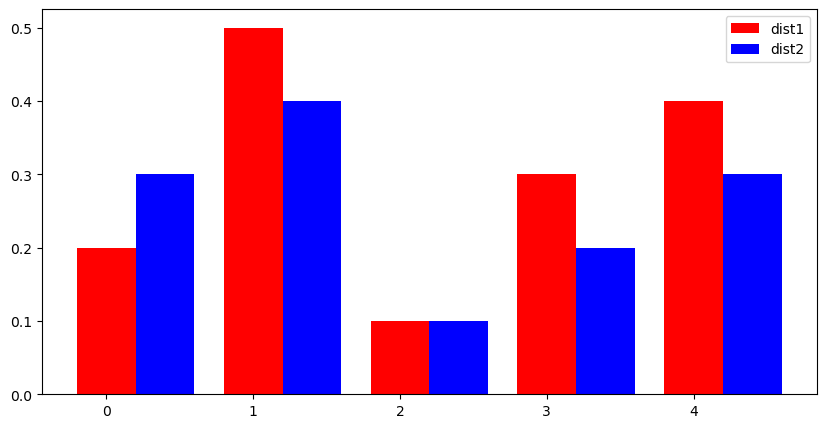

In [14]:
import matplotlib.pyplot as plt
 
# creating the dataset
x = [0,1,2,3,4]
y = [0.2, 0.5, 0.1, 0.3, 0.4]
x2 = [0.4,1.4,2.4,3.4,4.4]
y2 = [0.3, 0.4, 0.1, 0.2, 0.3]

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(x, y, color ='red', width = 0.4,label="dist1")
plt.bar(x2, y2, color ='blue', width = 0.4,label="dist2")
plt.legend()
plt.show()

![36t-SNE_1_0](https://github.com/FlyingWhalesHQ/flying-whales-blog/assets/7457301/90c71253-0eaf-424e-850d-34d5b1462f90)

Analytically, the KL divergence is calculated as follows:

$$ D_{KL}(p_X, p_Y) = \sum p_X(x) log(\frac{p_X(x)}{p_Y(x)}) $$

$$ = 0.2 log(\frac{0.2}{0.3}) + 0.5 log(\frac{0.5}{0.4}) + 0.1 log(\frac{0.1}{0.1}) + 0.3 log(\frac{0.3}{0.2}) + 0.4 log(\frac{0.4}{0.3}) = 0.267 $$

### Code example

Given two distributions, let's calculate the KL divergence of these two using code and using the provided function by scipy library in Python.

In [6]:
dist1 = [0.2, 0.5, 0.1, 0.3, 0.4]
dist2 = [0.3, 0.4, 0.1, 0.2, 0.3]

import numpy as np
from scipy.special import rel_entr

def kl_divergence(d1, d2):
    return sum(d1[i] * np.log(d1[i]/d2[i]) for i in range(len(d1)))

print ("KL divergence (d1 || d1): {}".format(kl_divergence(dist1, dist1)))
print ("KL divergence (d1 || d2): {}".format(kl_divergence(dist1, dist2)))

print("--------------------")
print("With scipy rel_entr function")

print ("KL divergence (d1 || d1): {}".format(sum(rel_entr(dist1, dist1))))
print ("KL divergence (d1 || d2): {}".format(sum(rel_entr(dist1, dist2))))


KL divergence (d1 || d1): 0.0
KL divergence (d1 || d2): 0.2671911154486337
--------------------
With scipy rel_entr function
KL divergence (d1 || d1): 0.0
KL divergence (d1 || d2): 0.2671911154486337


Note that since KL divergence is not a symmetric indicator ( $$ D_{KL}(p_X,p_Y) \neq D_{KL}(p_Y, p_X) $$), it is not really a distance measurement. It measures the dissimilarity. KL divergence and cross entropy can have many application. For example, in model selection, a model with smaller KL divergence or cross entropy suggests a "closer" prediction to true labels hence we can choose the it. In NLP, we can compare document-topic distribution divergence and make accordingly actions. In some variational auto encoders, KL divergence is used as a part of the loss function. It measures the difference between the learned distribution and the prior, pushing the learned distribution toward the prior during training. KL divergence and cross entropy can also be used for information retrieval when we compare a query to documents in a database to identify the most relevant matches. They also have some applications in reinforcement learning, when they are used to limit the update in each learning step, so that the new policy stays close to the old policy, making learning stable.

## Jensen Shannon divergence

Jensen Shannon (JS) divergence is a weighted sum of KL divergence since it makes a symmetric indicatior out of KL:

$$ D_{JS} (p_X, p_Y) = \frac{1}{2} D_{KL} (p_X \mid \mid \frac{p_X + p_Y}{2}) + \frac{1}{2} D_{KL} (p_Y \mid \mid \frac{p_X + p_Y}{2}) $$

Since it takes the average of the two distributions and measure the KL difference between each distribution to the average, (and take average of that), it is also called total divergence to the average. The distribution after taking average of the two distributions is called the mixture probability distribution. 

<img src="https://miro.medium.com/v2/resize:fit:1400/0*FeaFgw2gjfHGs9fv">

Image: Getting a mixture distribution

For discrete variables, the mixture distribution is $$ \frac{p_X(x) + p_Y(x)}{2} $$ and the discrete form of JS divergence is:

$$ \frac{1}{2} \sum p_X(x) * log(\frac{p_X(x)}{mixture(x)}) + \frac{1}{2} \sum p_Y(x) * log(\frac{p_Y(x)}{mixture(x)}) $$

Some differences with the KL divergence include its symmetry and finite nature. The JS divergence is bounded by 0 and 1 if we use the base 2 logarithm, and it is bounded by 0 and log(2) if we use base e (natural logarithm). As above, if we use $$ log_2 $$ we result in bit and if we use $$ log_e $$ we result in nat. The squareroot of JS divergence is called JS distance.

JS divergence can be used for drift monitoring: to detect changes between training distribution and production distribution to retrain (adapt) the model with the change. It can also be used to make sure that input or output data in production doesn't change drammatically from a baseline. 

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*gmLORPLZTyzxUTW7k7WHnQ.jpeg">

Image: Compare prodcution and baseline to mixture

### Code example

In [28]:
dist1 = [0.2, 0.5, 0.1, 0.3, 0.4]
dist2 = [0.3, 0.4, 0.1, 0.2, 0.3]

# calculate the js divergence
def js_divergence(d1, d2):
 m = 0.5 * (np.array(d1) + np.array(d2))
 return 0.5 * kl_divergence(d1, m) + 0.5 * kl_divergence(d2, m)

print("JS divergence in base e")
print("JS divergence (d1 || d2): {} nats".format(js_divergence(dist1,dist2)))
print("JS divergence (d2 || d1): {} nats".format(js_divergence(dist2,dist1)))
print("JS distance (d2 || d1): {}".format(np.sqrt(js_divergence(dist2,dist1))))

print("--------------------------")
print("JS divergence in base 2")
def kl_divergence_base2(d1, d2):
    return sum(d1[i] * np.log2(d1[i]/d2[i]) for i in range(len(d1)))
def js_divergence_base2(d1, d2):
 m = 0.5 * (np.array(d1) + np.array(d2))
 return 0.5 * kl_divergence_base2(d1, m) + 0.5 * kl_divergence_base2(d2, m)

print("JS divergence (d1 || d2): {} bits".format(js_divergence_base2(dist1,dist2)))
print("JS divergence (d2 || d1): {} bits".format(js_divergence_base2(dist2,dist1)))
print("JS distance (d2 || d1): {}".format(np.sqrt(js_divergence_base2(dist2,dist1))))


JS divergence in base e
JS divergence (d1 || d2): 0.016434955109340163 nats
JS divergence (d2 || d1): 0.016434955109340163 nats
JS distance (d2 || d1): 0.1281988888771668
--------------------------
JS divergence in base 2
JS divergence (d1 || d2): 0.023710628233477783 bits
JS divergence (d2 || d1): 0.023710628233477783 bits
JS distance (d2 || d1): 0.153982558211889


# t-SNE

Stochastic neighbor embedding (SNE) is developed by Geoffrey Hinton and Sam Roweis in 2002, then is developed further into t-SNE by Geoffrey Hinton and Laurens van der Maaten in 2008. The most critical difference between SNE and t-SNE is the cost function. When SNE uses KL divergence, it tends to preserve small pairwise distance at the cost of large pairwise distance. t-SNE, on the other hand, combines KL divergence with a symmetry term, this improvement gives a balance between preserving local and global structure. Another difference is to solve the crowding issue: when high dimensional data is reduced into low dimensional space, data points tend to crowd together. t-SNE uses a t-distributed distribution instead of a Gaussian distribution (in SNE) so that there are more space for data points in the lower dimensional space. For optimization, t-SNE uses gradient descent with momentum. t-SNE tends to be more robust and provides better visualizations.

## Stochastic neighbor embedding

According to the authors, stochastic neighbor embedding is a probabilistic approach to place objects of high dimensional vetors (or pairwise dissimilarities) into a low dimensional space that preserves the neighbor identities. Preserving neighbor identities appears to be more sophisticated than just keeping similar words together. There are ambiguous word, like "bank", that should be close to both "river", and "finance" in some ways so that "river" doesn't have to be close to "finance". It is the main contribution of this probabilistic method, to make it easy to represent each object by a mixture of widely separated low dimensional features. 

For object i, and a neighbor j, we compute the asymmetric probability $$ p_{ij} $$ that i would choose j as its neighbour:

$$ p_{ij} = \frac{exp(-d_{ij}^2)}{\sum_{k \neq i} exp(-d_{ik}^2)} $$

with $$ d_{ij}^2 $$ to be the dissimilarity which can be given, or to be calculated as the scaled squared Euclidean distance (called affinity) between two high dimensional data points $$ x_i, x_j $$: $$ d_{ij}^2 = \frac{\mid \mid x_i - x_j \mid \mid^2}{2 \sigma_i^2} $$. $$ \sigma_i $$ is set or to be found by a binary search so that the entropy of the distribution over neighbors equal $$ log k $$, k is the number of local neighbors, (called perplexity), and is chosen. So SNE converts high dimensional Euclidean distance between datapoints into conditional probabilities that represent similarities.

The low dimensional space is characterized by Gaussian with fixed variance equal to 1/2. So $$p_{ij} $$ becomes $$ q_{ij} $$ in lower dimensions and $$ q_{ij} = \frac{exp(-\mid\mid y_i - y_j\mid\mid^2)}{\sum_{k \neq i} exp(-\mid\mid y_i - y_k\mid\mid^2)} $$

The purpose is to match the two distribution $$p_{ij} $$ and $$q_{ij}$$ as much as possible. The authors use KL divergence:

$$ L = \sum_i \sum_j p_{ij} log \frac{p_{ij}}{q_{ij}} = \sum_i KL (P_i \mid\mid Q_i) $$

This method emphasizes local distance, enforcing nearby objects' images nearby and far objects' images far apart.

To minimize the loss function (KL divergence), the authors differencing it:

$$ \frac{\delta L}{\delta y_i} = 2 \sum_j (y_i - y_j) (p_{ij} - q_{ij} + p_{ji} - q_{ji}) $$

They add random jitter to the gradient descent, to find better local optima. Here is the result of SNE on MNIST dataset:

<img width="542" alt="Screenshot 2023-05-29 at 17 58 13" src="https://github.com/FlyingWhalesHQ/flying-whales-blog/assets/7457301/5307028a-5dff-4a5b-a9c4-31188e5dbb3d">

## t-SNE

t-SNE improves over SNE in that it reduces the tendency to crowd data points together in the center of the map. It converts high dimensional dataset into a matrix of pairwise dissimilarities and then visualize them. It can shows the local differences and also the global structure such as clusters at different scales. 

The first difference is in the cost function, t-SNE uses a symmetrized version of KL divergence with simpler gradient. The second difference is that t-SNE uses a Student-t distribution rather than a Gaussian to compute the similarity between two points in the low dimensional space. This heavy-tailed distribution alleviates the crowding problem and the optimization issues.

To symmetrize the KL divergence, the authors use:

$$ L = KL(P \mid\mid Q) = \sum_i \sum_j p_{ij} log \frac{p_{ij}}{q_{ij}} $$

$$ $$ 

$$ p_{ii} = q_{ii} = 0 $$ and the consequence is that $$ p_{ij} = p_{ji} $$ and $$ q_{ij} = q_{ji} $$ for all i, j. In the low dimensional space, $$ q_{ij} = \frac{exp(-\mid\mid y_i - y_j \mid\mid^2)}{\sum_{k \neq l} exp(- \mid\mid y_k - y_l \mid\mid^2)} $$

The joint probabilities $$ p_{ij} $$ in high dimensional space is the symmetrized conditional probabilities $$ p_{ij} = \frac{p_{j\mid i} + p_{i \mid j}}{2n} $$. This makes sure that $$ \sum_j p_{ij} > \frac{1}{2n} $$ for all data point $$ x_i $$ so that each data point makes a good contribution to the cost function. The gradient is also easier to compute: 

$$ \frac{\delta L}{\delta y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j) $$. 

$$ $$

For the crowding issue, it is naturally alleviated as follows. In the high dimensional space, the distances are converted into probabilites using a Gaussian distribution but in the low dimensional map, they use a heavy tailed distribution to convert distances into probabilities. That heavy tailed distribution is chosen to be a student-t distribution with one degree of freedom (which is a Cauchy distribution). $$ q_{ij} $$ then becomes:

$$ q_{ij} = \frac{(1+\mid\mid y_i - y_j \mid\mid^2)^{-1}}{\sum_{k \neq l} (1 + \mid \mid y_k - y_l \mid\mid^2)^{-1}} $$

The gradient becomes:

$$ \frac{\delta L}{\delta y_i } = 4 \sum_j (p_{ij} - q_{ij} )(y_i - y_j) (1+\mid\mid y_i - y_j\mid\mid^2)^{-1} $$

This gradient repels different datapoints modeled closely so dissimilar datapoints would be in large pairwise distance. And similar datapoints would be close. The optimization is also easier. t-SNE has a long range forces that can pull close two clusters that get separated early in the optimization process.

<img width="489" alt="Screenshot 2023-05-29 at 19 24 13" src="https://github.com/FlyingWhalesHQ/flying-whales-blog/assets/7457301/558ca791-936c-4e90-ae9e-a7b1fca5fae8">

Image: t-SNE visualization of MNIST
